# MedARC fMRI foundation model quickstart

In this notebook, we will:

- load a pretrained flat map MAE (fm-MAE) model from the [huggingface hub](https://huggingface.co/medarc/fm_mae_vit_base_patch16-16.hcp)
- load sample fMRI data from [hcp-flat-wds](https://huggingface.co/datasets/medarc/hcp-flat-wds)
- visualize masked reconstruction predictions for the sample input.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download

from data.flat_data import make_flat_wds_dataset, make_flat_transform
import flat_mae.models_mae as models_mae
from flat_mae.visualization import FC_CMAP, plot_mask_pred

In [2]:
plt.rcParams["figure.dpi"] = 100

Load a pretrained checkpoint for a ViT-B/16 encoder with temporal patch size 16.

In [3]:
model = models_mae.MaskedAutoencoderViT.from_pretrained("medarc/fm_mae_vit_base_patch16-16.hcp")
print(model)

num_params = sum(p.numel() for p in model.parameters())
num_params_encoder = sum(p.numel() for p in model.encoder.parameters())

print(f"num params (total): {num_params / 1e6:.1f}M")
print(f"num params (encoder): {num_params_encoder / 1e6:.1f}M")

MaskedAutoencoderViT(
  decoding=attn, t_pred_stride=2, pred_edge_pad=0, no_decode_pos=False
  (encoder): MaskedEncoder(
    class_token=True, reg_tokens=0, no_embed_class=False, mask_drop_scale=False
    (patchify): Patchify3D((16, 224, 560), (16, 16, 16), in_chans=1)
    (patch_embed): Linear(in_features=4096, out_features=768, bias=True)
    (pos_embed): SeparablePosEmbed(768, (1, 14, 35))
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          num_heads=12
          (q): Linear(in_features=768, out_features=768, bias=True)
          (k): Linear(in_features=768, out_features=768, bias=True)
          (v): Linear(in_features=768, out_features=768, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linea

Download one example [webdataset](https://github.com/webdataset/webdataset) data shard from [hcp-flat-wds](https://huggingface.co/datasets/medarc/hcp-flat-wds).

⚠️ You'll need to accept the HCP data use agreement to get gated access to the dataset. You may also need to authenticate with `hf auth login` or run

```python
from huggingface_hub import login
login()
```

In [4]:
url = hf_hub_download("medarc/hcp-flat-wds", "hcp-flat_0000.tar", repo_type="dataset")

Create the dataset.

In [5]:
dataset = make_flat_wds_dataset(url, clipping="sequential", shuffle=False)
transform = make_flat_transform(normalize="frame")

dataset = dataset.map(transform)

sample = next(iter(dataset))
print(sample.keys())
print(sample["__key__"])

dict_keys(['image', 'img_mask', '__key__'])
sub-349244_mod-tfMRI_task-RELATIONAL_mag-3T_dir-RL


Inspect the image data and flat map mask.

In [6]:
img = sample["image"]
mask = sample["img_mask"]
print(img.shape, img.dtype)
print(mask.shape, mask.dtype)

torch.Size([1, 16, 224, 560]) torch.float32
torch.Size([224, 560]) torch.float32


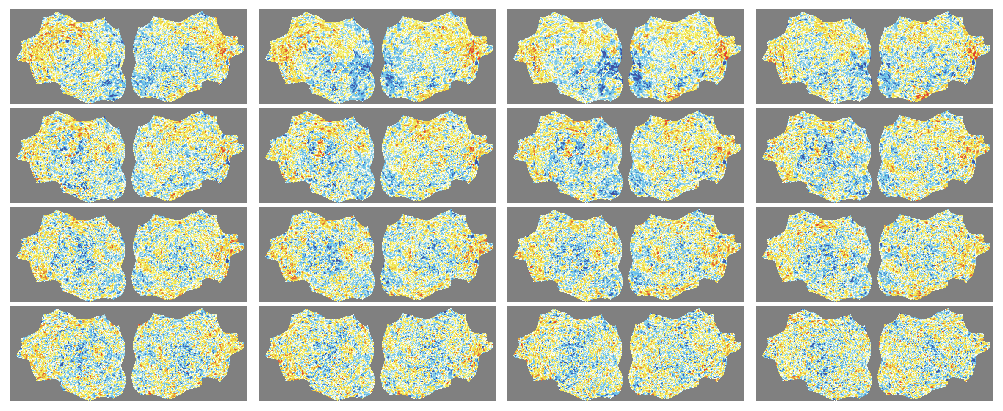

In [7]:
H, W = img.shape[2:]
ploth = 1.0
plotw = (W / H) * ploth

nr = 4
nc = 4

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii, ax in enumerate(axs):
    plt.sca(ax)
    plt.imshow(
        np.where(mask > 0, img[0, ii], np.nan), vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none"
    )
    plt.axis("off")

plt.tight_layout(pad=0.3)

Run the model to generate predictions and compute the MAE MSE loss.

In [8]:
torch.manual_seed(42)  # seed for reproducible masking, bit hacky

images = img[None, ...]  # [B, C, T, H, W]
masks = mask.expand_as(images)

loss, state = model(images, img_mask=masks, mask_ratio=0.9)

print(f"MAE MSE loss: {loss:.4f}")

MAE MSE loss: 0.8250


Plot the masked reconstruction predictions. Each row is a temporal frame spaced 2 frames = 2 sec apart. The left column is the masked input, the middle is the model prediction (with pasted observed patches), and the right is the target data.

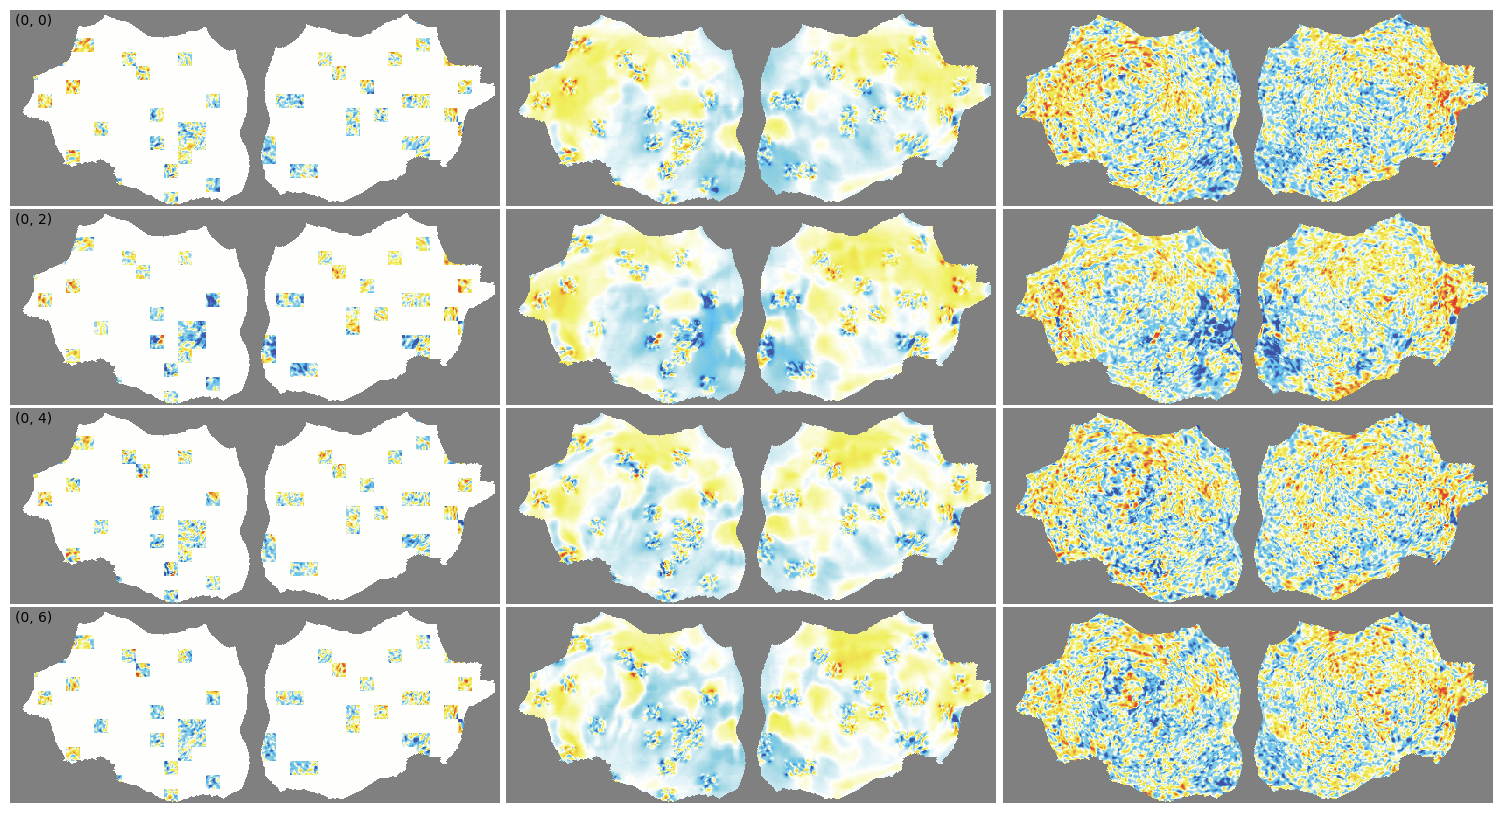

In [9]:
plot_mask_pred(
    target=images,
    pred=state["pred_images"],
    visible_mask=state["visible_mask"],
    pred_mask=state["pred_mask"],
    img_mask=masks,
    nrow=4,
);